In [102]:
from torch_geometric.data import Data
import torch

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

import pubchempy as pcp
import sys
import re


# Add src folder to the sys.path
src_path = "../src"
sys.path.insert(0, src_path)

from oxides_ml.dataset import OxidesGraphDataset
from oxides_ml.graph_tools import graph_plotter

graph_params = {"structure": {"tolerance": 0.25, "scaling_factor": 1.25, "second_order": True},
                "features": {"adsorbate": False, "radical": False, "valence": False, "gcn": False, "magnetization": False},
                "target": "adsorption_energy"}

vasp_directory = "/BACKUP/database"
graph_dataset_dir = "/home/tvanhout/oxides_ML/models/test_graph_datasets"

dataset = OxidesGraphDataset(vasp_directory, graph_dataset_dir, graph_params, initial_state=False, force_reload=False, augment=False)
len(dataset)

514

# Determine Connectivity

In [103]:
def subtract_graphs(G_total, G_slab, G_gas):
    """Subtracts the slab and gas-phase graphs from the total graph to extract adsorbate connectivity."""
    # Combine edges from slab and gas-phase molecule
    combined_edges = torch.cat([G_slab.edge_index, G_gas.edge_index], dim=1)
    
    # Identify new edges in G_total that are not in the combined system
    mask = ~(G_total.edge_index.unsqueeze(2) == combined_edges.unsqueeze(1)).all(dim=0).any(dim=1)
    new_edges = G_total.edge_index[:, mask]

    # Extract new node features (adsorbate-specific)
    new_node_features = None
    if G_total.x is not None and G_slab.x is not None and G_gas.x is not None:
        num_slab_nodes = G_slab.x.shape[0]
        num_gas_nodes = G_gas.x.shape[0]
        new_node_features = G_total.x[num_slab_nodes + num_gas_nodes:]  # Adsorbate-specific nodes

    # Extract adsorption energy if available
    ads_energy = G_total.ads_energy if hasattr(G_total, "ads_energy") else None

    # Extract surface if available
    material = G_total.material if hasattr(G_total, "material") else None

    # Extract molecule if available
    adsorbate_name = G_total.adsorbate_name if hasattr(G_total, "adsorbate_name") else None

    # Extract molecule group if available
    adsorbate_group = G_total.adsorbate_group if hasattr(G_total, "adsorbate_group") else None

    # Create the new graph with the adsorption energy stored
    G_adsorbate = Data(x=new_node_features, edge_index=new_edges)
    if ads_energy is not None:
        G_adsorbate.ads_energy = ads_energy  # Attach adsorption energy

    if material is not None:
        G_adsorbate.material = material # Attach surface

    if adsorbate_name is not None:
        G_adsorbate.adsorbate_name = adsorbate_name # Attach adsorbate_name

    if adsorbate_group is not None:
        G_adsorbate.adsorbate_group = adsorbate_group # Attach adsorbate_group

    return G_adsorbate

G_gas = None
G_slab = None
G_totals = []  # Store all adsorbate configurations
G_adsorbate_list = []  # List to store all computed G_adsorbate graphs

# Step 1: Extract relevant graphs from dataset
for graph in dataset:
    if graph.adsorbate_name == graph.adsorbate_name and graph.type == 'gas':
        G_gas = graph  # Gas-phase molecule
    elif graph.material == graph.material and graph.type == 'slab':
        G_slab = graph  # Clean slab
    elif graph.adsorbate_name == graph.adsorbate_name and graph.material == graph.material and graph.type == 'adsorbate':
        G_totals.append(graph)  # Collect all adsorption configurations

# Step 2: Check if necessary components exist
if G_gas is None:
    print("Error: Gas-phase molecule graph not found.")
if G_slab is None:
    print("Error: Slab graph not found.")
if len(G_totals) == 0:
    print("Error: No adsorption graphs found.")

# Step 3: Compute and store G_adsorbate for each adsorption instance
for idx, G_total in enumerate(G_totals):
    G_adsorbate = subtract_graphs(G_total, G_slab, G_gas)
    G_adsorbate_list.append(G_adsorbate)  # Append to the list

    # Print energy to verify it's being stored correctly
    #print(f"Graph {idx}: Adsorption Energy = {G_adsorbate.ads_energy}")

# Step 4: Verify that results are stored
print(f"Number of extracted adsorbate graphs: {len(G_adsorbate_list)}")

# for graph in G_adsorbate_list:
#     print(graph)

Number of extracted adsorbate graphs: 479


# Determine adsorption sites (relaxed)

In [104]:
def find_adsorption_sites(G_adsorbate, G_slab):
    """Identify adsorption site by finding slab atoms connected to the adsorbate in G_adsorbate."""
    adsorption_sites = set()

    # Assume the adsorbate starts after slab nodes in G_total
    num_slab_nodes = G_slab.x.shape[0]

    for edge in G_adsorbate.edge_index.T:  # Iterate over edges
        node1, node2 = edge.tolist()

        # One node must be from the slab, the other from the adsorbate
        if (node1 < num_slab_nodes and node2 >= num_slab_nodes) or (node2 < num_slab_nodes and node1 >= num_slab_nodes):
            adsorption_sites.add(node1 if node1 < num_slab_nodes else node2)  # Store slab atom index

    return sorted(list(adsorption_sites))  # Return sorted slab atom indices

# Example: Process all adsorbate graphs
adsorption_sites_list = []

for idx, G_adsorbate in enumerate(G_adsorbate_list):
    adsorption_sites = find_adsorption_sites(G_adsorbate, G_slab)
    adsorption_sites_list.append(adsorption_sites)
    
    # print(f"Graph {idx}: Adsorption Sites = {adsorption_sites}")


In [105]:
# Dictionary to store unique adsorption sites
unique_adsorption_sites = defaultdict(int)

# Iterate over the list of G_adsorbate graphs and track adsorption sites
for idx, G_adsorbate in enumerate(G_adsorbate_list):
    adsorption_sites = find_adsorption_sites(G_adsorbate, G_slab)
    
    # Convert list to a tuple to make it hashable for storage in a dictionary
    adsorption_sites_tuple = tuple(sorted(adsorption_sites))  # Ensure the list is sorted to normalize order
    
    # Increment count of this unique adsorption site
    unique_adsorption_sites[adsorption_sites_tuple] += 1

# Now you have all unique adsorption site configurations with their frequency count
# Print out unique adsorption sites and how often they occur
print("Unique Adsorption Site Configurations and Their Counts:")
for sites, count in unique_adsorption_sites.items():
    print(f"Adsorption Sites: {sites}, Count: {count}")

Unique Adsorption Site Configurations and Their Counts:
Adsorption Sites: (34,), Count: 11
Adsorption Sites: (4,), Count: 12
Adsorption Sites: (24,), Count: 190
Adsorption Sites: (4, 24), Count: 57
Adsorption Sites: (), Count: 126
Adsorption Sites: (24, 109), Count: 22
Adsorption Sites: (69, 109), Count: 4
Adsorption Sites: (19, 69, 109), Count: 3
Adsorption Sites: (4, 24, 69), Count: 8
Adsorption Sites: (4, 24, 109), Count: 18
Adsorption Sites: (14, 69), Count: 1
Adsorption Sites: (4, 24, 89), Count: 8
Adsorption Sites: (14, 34, 69), Count: 2
Adsorption Sites: (24, 89), Count: 2
Adsorption Sites: (4, 49), Count: 2
Adsorption Sites: (4, 24, 39, 109), Count: 1
Adsorption Sites: (14, 34), Count: 2
Adsorption Sites: (34, 69, 109), Count: 2
Adsorption Sites: (4, 24, 69, 109), Count: 1
Adsorption Sites: (109,), Count: 4
Adsorption Sites: (4, 69), Count: 1
Adsorption Sites: (34, 109), Count: 2


In [106]:
# Define the mapping from adsorption site configurations to labels
adsorption_site_map = {
    (34,): 'Metal',
    (4,): 'Metal',
    (24,): 'Metal',
    (4, 24): 'Metal Bridge',
    (): 'Physisorbed',
    (24, 109): 'Hole',
    (69, 109): 'Oxygen Bridge',
    (19, 69, 109): 'Oxygen Bridge',
    (4, 24, 69): 'Metal Bridge',
    (4, 24, 109): 'Metal Bridge',
    (14, 69): 'Metal',
    (4, 24, 89): 'Metal Bridge',
    (14, 34, 69): 'Metal Bridge',
    (24, 89): 'Metal',
    (4, 49): 'Metal',
    (4, 24, 39, 109): 'Metal Bridge',
    (14, 34): 'Metal Bridge',
    (34, 69, 109): 'Oxygen Bridge',
    (4, 24, 69, 109): 'Metal Bridge',
    (109,): 'Oxygen',
    (4, 69): 'Metal',
    (34, 109): 'Metal'
}

def classify_adsorption_sites(adsorption_sites):
    """Assigns a label based on the adsorption site positions using predefined map."""
    adsorption_sites_tuple = tuple(sorted(adsorption_sites))  # Sort to standardize the representation
    return adsorption_site_map.get(adsorption_sites_tuple, 'Unknown')  # Default to 'Unknown' if not found

def assign_adsorption_label(G_adsorbate):
    """Assigns a string label to the graph based on adsorption site."""
    adsorption_sites = find_adsorption_sites(G_adsorbate, G_slab)
    label = classify_adsorption_sites(adsorption_sites)  # Get the label based on adsorption site
    return label

# Step 1: Assign labels to each graph in G_adsorbate_list
for idx, G_adsorbate in enumerate(G_adsorbate_list):
    label = assign_adsorption_label(G_adsorbate)
    G_adsorbate.adsorption_label = label  # Assign the label as a property of the graph

    # Optional: Print the label for each graph
    # print(f"Graph {idx}: Adsorption Label = {label}")

# for graph in G_adsorbate_list:
#     print(graph)

# Data analysis of dataset

In [107]:
data = []
for G_adsorbate in G_adsorbate_list:
    # Create a dictionary for each graph's information
    graph_data = {
        "material": getattr(G_adsorbate, "material", None),  # Surface material
        "adsorbate_group": getattr(G_adsorbate, "adsorbate_group", None),  # Adsorbate group
        "adsorbate_name": getattr(G_adsorbate, "adsorbate_name", None),  # Adsorbate name
        "adsorption_label": getattr(G_adsorbate, "adsorption_label", None),  # Adsorption label
        "ads_energy": G_adsorbate.ads_energy.item() if G_adsorbate.ads_energy is not None else None,  # Convert tensor to value
    }
    data.append(graph_data)

df = pd.DataFrame(data)

df.head(10)

,material,adsorbate_group,adsorbate_name,adsorption_label,ads_energy
0,RuO2,alcohols_aldehydes_ketones_ethers,Acetaldehyde,Metal,-1.285223
1,RuO2,alcohols_aldehydes_ketones_ethers,Acetaldehyde,Metal,-1.376368
2,RuO2,alcohols_aldehydes_ketones_ethers,Acetaldehyde,Metal,-0.494098
3,RuO2,alcohols_aldehydes_ketones_ethers,Acetaldehyde,Metal,-1.376956
4,RuO2,alcohols_aldehydes_ketones_ethers,Ethanol,Metal Bridge,-1.717263
5,RuO2,alcohols_aldehydes_ketones_ethers,Ethanol,Metal,-0.690331
6,RuO2,alcohols_aldehydes_ketones_ethers,Ethanol,Physisorbed,-0.406523
7,RuO2,alcohols_aldehydes_ketones_ethers,Ethanol,Metal,-0.725645
8,RuO2,alcohols_aldehydes_ketones_ethers,Ethanol,Metal,-1.626952
9,RuO2,alcohols_aldehydes_ketones_ethers,Ethanol,Metal,-0.689061


/tmp/ipykernel_2073085/3602221888.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')


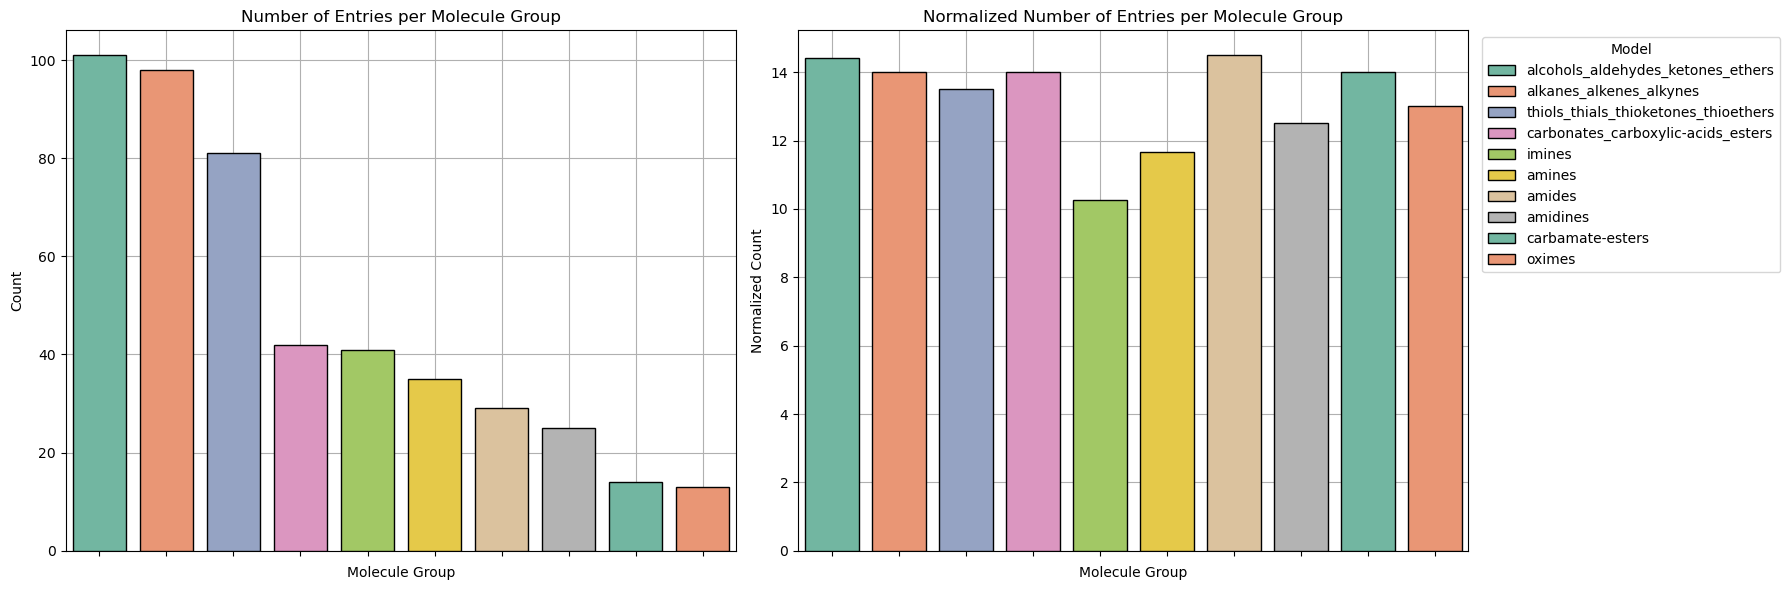

In [108]:
group_counts = df['adsorbate_group'].value_counts().reset_index()
group_counts.columns = ["adsorbate_group", "count"]

molecule_counts = df.groupby("adsorbate_group")["adsorbate_name"].nunique().reset_index()
molecule_counts.columns = ["adsorbate_group", "total_molecules"]

group_counts = group_counts.merge(molecule_counts, on="adsorbate_group")
group_counts["normalized_count"] = group_counts["count"] / group_counts["total_molecules"]


fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

# First plot: Count of each adsorption group
sns.barplot(x="adsorbate_group", y="count", data=group_counts, hue="adsorbate_group", palette="Set2", legend=False, edgecolor='black', zorder=10, ax=axes[0])
axes[0].set_title("Number of Entries per Molecule Group")
axes[0].set_xlabel("Molecule Group")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_xticklabels([])
axes[0].grid(True)

# Second plot: Normalized count per adsorption group
sns.barplot(x="adsorbate_group", y="normalized_count", data=group_counts, hue="adsorbate_group", palette="Set2", legend=True, edgecolor='black', zorder=10, ax=axes[1])
axes[1].set_title("Normalized Number of Entries per Molecule Group")
axes[1].set_xlabel("Molecule Group")
axes[1].set_ylabel("Normalized Count")
#axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_xticklabels([])
axes[1].grid(True)
axes[1].legend(title='Model', bbox_to_anchor=(1.01, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

plt.show()


# Global Energy Distribution

/tmp/ipykernel_2073085/3358031228.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df, x="ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10,  ax=axes[0])


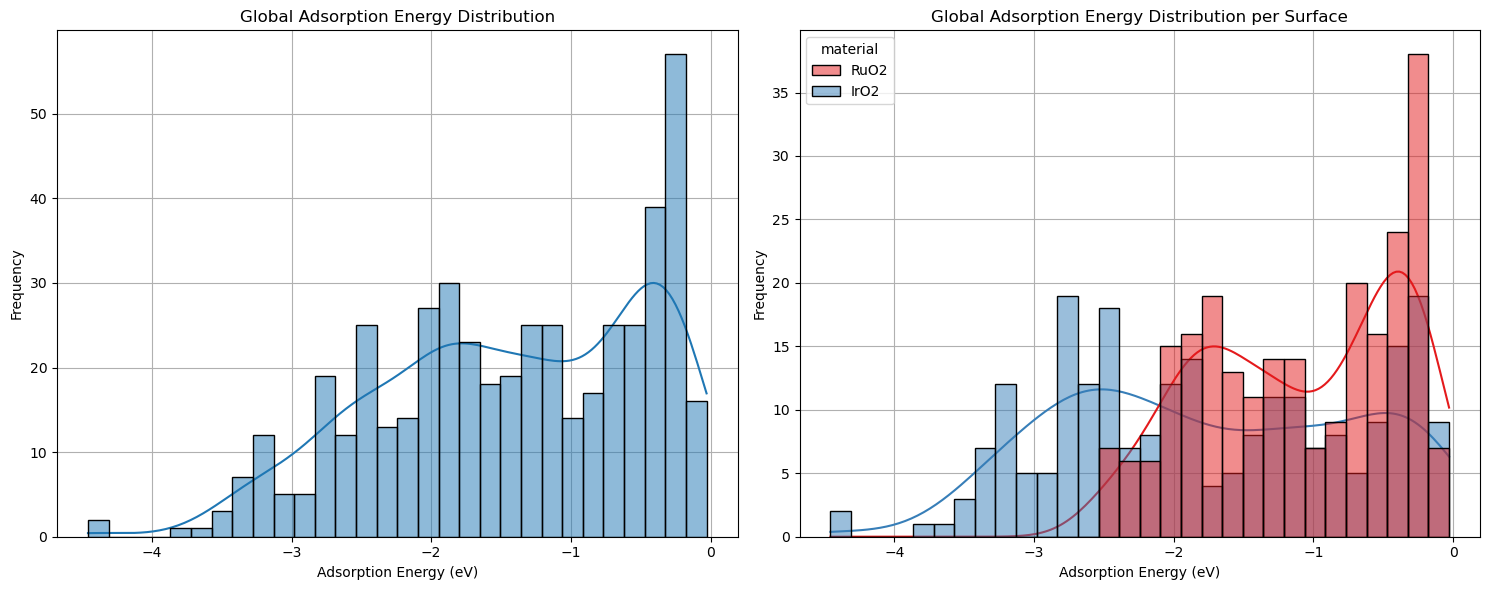

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# First plot
sns.histplot(df, x="ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10,  ax=axes[0])
axes[0].set_title("Global Adsorption Energy Distribution")
axes[0].set_xlabel("Adsorption Energy (eV)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# Second plot
sns.histplot(df, x="ads_energy", hue="material", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[1])
axes[1].set_title("Global Adsorption Energy Distribution per Surface")
axes[1].set_xlabel("Adsorption Energy (eV)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

# Adjust layout
plt.tight_layout()

plt.show()

# Final site insights

/tmp/ipykernel_2073085/1401505413.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])


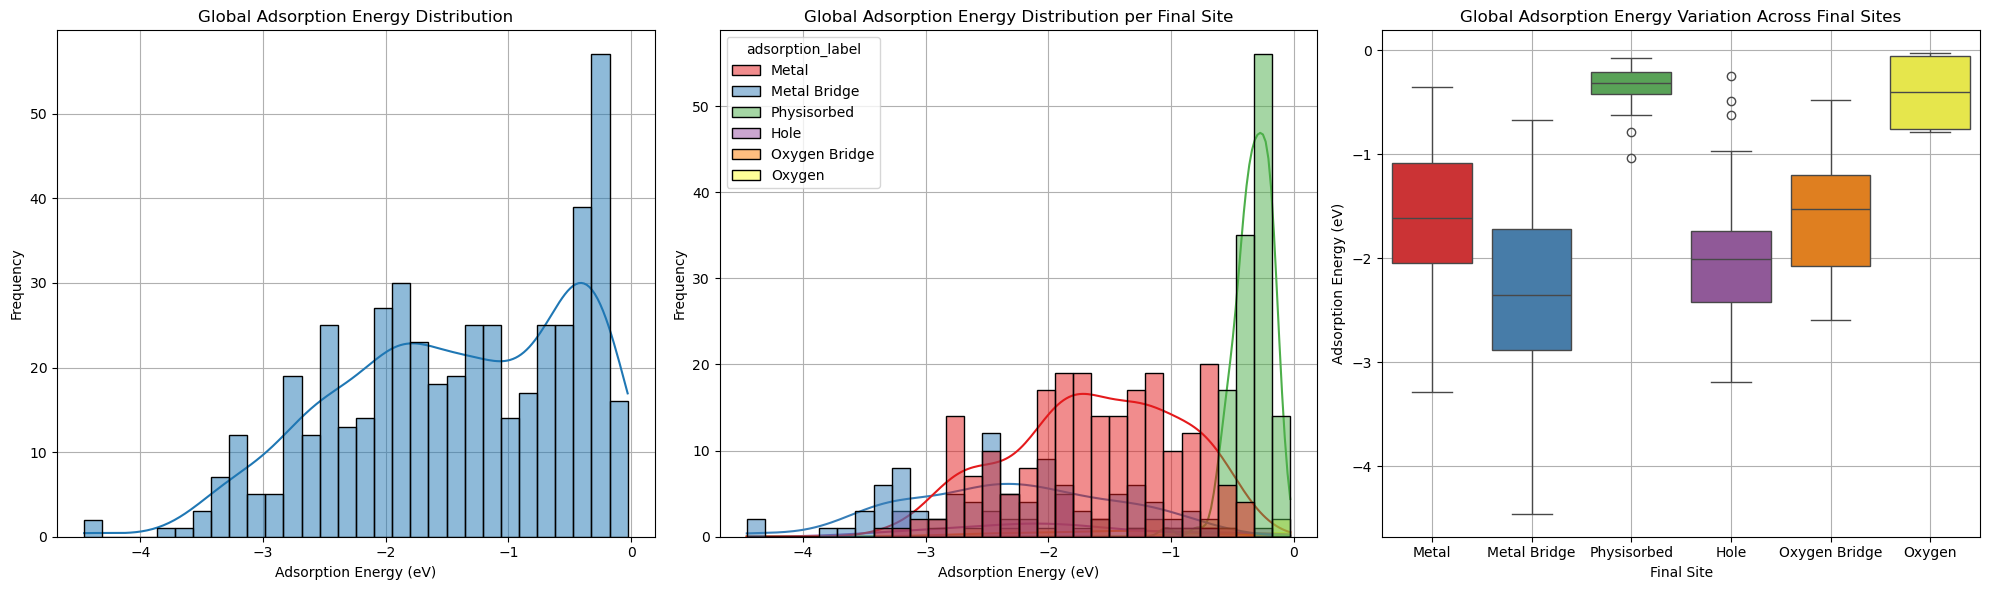

In [110]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

# First plot
sns.histplot(df, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])
axes[0].set_title("Global Adsorption Energy Distribution")
axes[0].set_xlabel("Adsorption Energy (eV)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# Second plot
sns.histplot(df, x = "ads_energy", hue = 'adsorption_label', bins=30, kde=True, palette="Set1" , edgecolor='black', zorder=10, ax=axes[1])
axes[1].set_title("Global Adsorption Energy Distribution per Final Site")
axes[1].set_xlabel("Adsorption Energy (eV)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

# Third plot
sns.boxplot(df, x="adsorption_label", y="ads_energy", hue = "adsorption_label", palette="Set1", legend=False , ax=axes[2])
axes[2].set_title("Global Adsorption Energy Variation Across Final Sites")
axes[2].set_ylabel("Adsorption Energy (eV)")
axes[2].set_xlabel("Final Site")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()

plt.show()

/tmp/ipykernel_2073085/1998332539.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_RuO2, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])


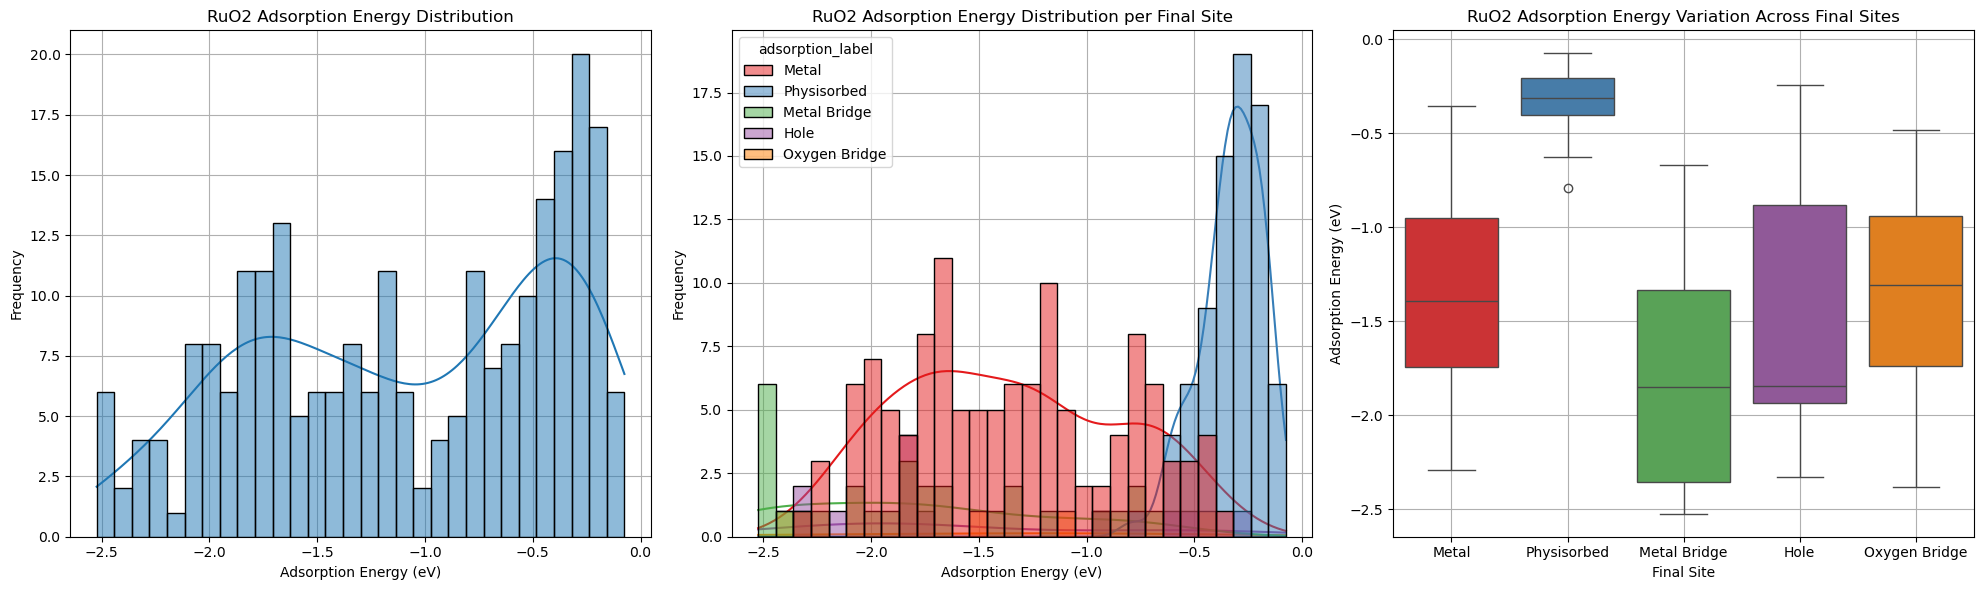

In [111]:
df_RuO2 = df[df['material'] == 'RuO2'].sort_values(by=['adsorbate_group']).reset_index(drop=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

# First plot
sns.histplot(df_RuO2, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])
axes[0].set_title("RuO2 Adsorption Energy Distribution")
axes[0].set_xlabel("Adsorption Energy (eV)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# Second plot
sns.histplot(df_RuO2, x = "ads_energy", hue = 'adsorption_label' , bins=30, kde=True, palette="Set1" , edgecolor='black', zorder=10, ax=axes[1])
axes[1].set_title("RuO2 Adsorption Energy Distribution per Final Site")
axes[1].set_xlabel("Adsorption Energy (eV)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

# Third plot
sns.boxplot(df_RuO2, x="adsorption_label", y="ads_energy", hue = "adsorption_label", palette="Set1", legend=False, ax=axes[2])
axes[2].set_title("RuO2 Adsorption Energy Variation Across Final Sites")
axes[2].set_ylabel("Adsorption Energy (eV)")
axes[2].set_xlabel("Final Site")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()

plt.show()

/tmp/ipykernel_2073085/2103276201.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_IrO2, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])


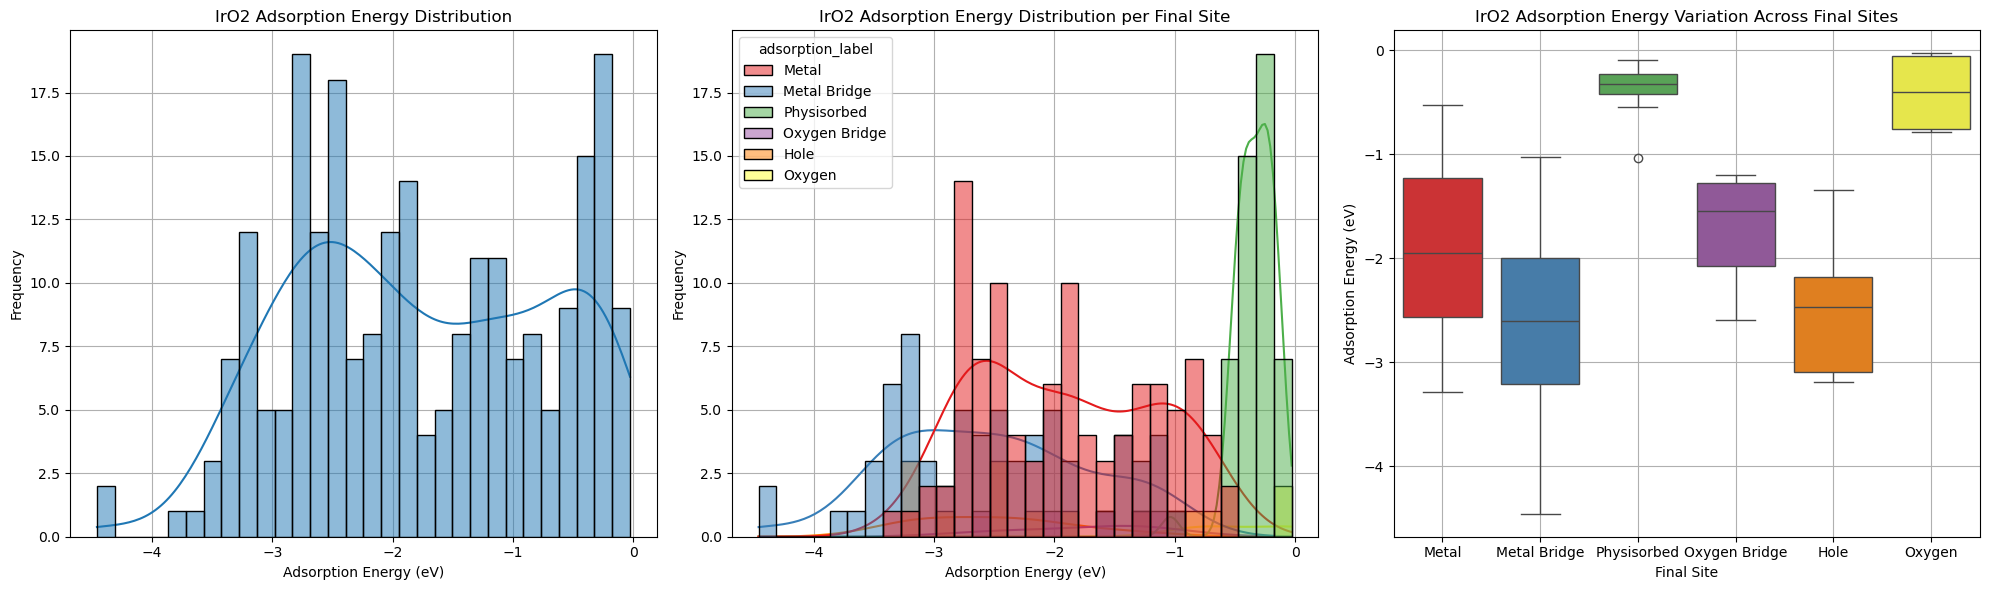

In [112]:
df_IrO2 = df[df['material'] == 'IrO2'].sort_values(by=['adsorbate_group']).reset_index(drop=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

# First plot
sns.histplot(df_IrO2, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])
axes[0].set_title("IrO2 Adsorption Energy Distribution")
axes[0].set_xlabel("Adsorption Energy (eV)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# Second plot
sns.histplot(df_IrO2, x = "ads_energy", hue = 'adsorption_label' , bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[1])
axes[1].set_title("IrO2 Adsorption Energy Distribution per Final Site")
axes[1].set_xlabel("Adsorption Energy (eV)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

# Third plot
sns.boxplot(df_IrO2, x="adsorption_label", y="ads_energy", hue = "adsorption_label", palette="Set1", legend=False, ax=axes[2])
axes[2].set_title("IrO2 Adsorption Energy Variation Across Final Sites")
axes[2].set_ylabel("Adsorption Energy (eV)")
axes[2].set_xlabel("Final Site")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()

plt.show()